# Airbender

In [195]:
# conda install pandas
# conda install matplotlib
# conda install -c derickl coremltools
import pandas as pd
import numpy as np
import glob

In [196]:
acc_names = ["acc" + str(x) for x in range(1, 51)]
acc_names.insert(0, "Gesture")
acc_names.insert(0, "Participant")
data_names = ["acc_x","acc_y","acc_z","gyr_x","gyr_y","gyr_z"]

all_files = glob.glob("./data_resampled_50/*.csv")

class_names = ["Gesture", "Participant"]
classes = range(0,12)

data = []

for file in all_files:
    df = pd.read_csv(file, sep=";", names=acc_names).dropna()
    data.append(df)
    
feature_bobs_names = ["feature_" + str(x) for x in range(1, 133)]
feature_bobs_names.insert(0, "Gesture")
feature_bobs_names.insert(0, "Participant")
data_names = ["acc_x","acc_y","acc_z","gyr_x","gyr_y","gyr_z"]
features_bobs = pd.read_csv("./features/features.csv", sep=";", names=feature_bobs_names).dropna()

In [197]:
features_bobs.shape

(600, 134)

In [198]:
features_bobs.iloc[0,:]

Participant          bobs1
Gesture                  0
feature_1       0.00669339
feature_2        0.0113547
feature_3       0.00450259
feature_4         0.016345
feature_5        0.0267999
feature_6         0.004732
feature_7         0.018481
feature_8        0.0328631
feature_9        0.0312593
feature_10       0.0285026
feature_11       0.0260564
feature_12       0.0314929
feature_13       0.0356456
feature_14       0.0283504
feature_15        0.024101
feature_16       0.0197877
feature_17        0.024101
feature_18       0.0283504
feature_19       0.0356456
feature_20       0.0314929
feature_21      0.00669339
feature_22       0.0113547
feature_23      0.00450259
feature_24        0.016345
feature_25       0.0267999
feature_26        0.004732
feature_27        0.018481
feature_28       0.0328631
                  ...     
feature_103       0.134808
feature_104       0.185278
feature_105        0.14068
feature_106       0.102708
feature_107      0.0361044
feature_108      0.0890069
f

In [199]:
import matplotlib.pyplot as plt

### Plot some info about data

In [200]:
data_x = data[0].values[:, ~data[0].columns.isin(class_names)]
plot_data = data_x[13].astype(np.float32, copy=False)

In [201]:
plot_data_rot2 = data[3].loc[data[1]["Gesture"] == 1, :].iloc[5,2:52].values
plot_data_rot2 = plot_data_rot2.astype(np.float32, copy=False)

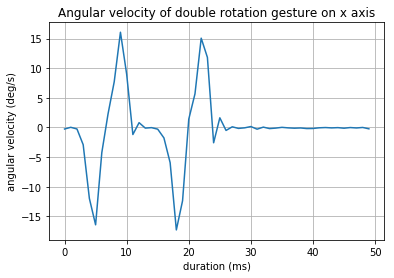

In [202]:
plt.plot(plot_data_rot2)
plt.title('Angular velocity of double rotation gesture on x axis')

plt.ylabel('angular velocity (deg/s)')
plt.xlabel('duration (ms)')

plt.grid(True)
plt.savefig('ang_x_double_rot.png')

## Features

In [203]:
features = pd.DataFrame()

### Time Domain

In [204]:
def get_time_feature(data, func):
    temp_feature = pd.DataFrame()
    count=0
    for frame in data:
        mean_df = pd.DataFrame(frame.iloc[:,2:].apply(func, axis=1), columns=[data_names[count] + "_" + func.__name__])
        temp_feature = pd.concat([temp_feature, mean_df], axis=1, sort=False)
        count+=1
        
    return temp_feature

### FFT

In [205]:
def get_magnitude_band(data, band_width):
    temp_feature = pd.DataFrame()
    def get_band(row, band_width, label):
        fft = np.fft.fft(row)
        magnitude = np.abs(fft)
        return pd.Series(magnitude[1:band_width+1],index=[label + "_" + str(x) for x in range(1,band_width+1)])

    count=0
    for frame in data:
        bands = frame.iloc[:,2:].apply(lambda x:get_band(x, band_width, data_names[count]), axis=1)
        temp_feature = pd.concat([temp_feature, bands], axis=1, sort=False)
        count+=1
    
    return temp_feature

### Combine features

In [206]:
time_mean_feature = get_time_feature(data, np.mean)
time_median_feature = get_time_feature(data, np.median)
band_feature = get_magnitude_band(data, 20)

features = pd.concat([data[0].iloc[:, 0:2], band_feature, time_mean_feature, time_median_feature], axis=1, sort=False)
features.head()

,Participant,Gesture,acc_x_1,acc_x_2,acc_x_3,acc_x_4,acc_x_5,acc_x_6,acc_x_7,acc_x_8,...,acc_z_mean,gyr_x_mean,gyr_y_mean,gyr_z_mean,acc_x_median,acc_y_median,acc_z_median,gyr_x_median,gyr_y_median,gyr_z_median
0,bobs1,0,0.415370,0.141621,0.354000,0.207618,0.144910,0.360604,0.761555,0.424918,...,-0.011518,0.151082,-0.049755,0.058895,-0.003490,-0.003490,-0.003490,-0.022883,-0.011255,0.000365
1,bobs1,1,0.467925,0.364173,0.189730,0.182268,0.520980,0.621774,0.122132,0.606170,...,0.011955,0.033986,-0.029323,-0.006534,0.007433,0.007433,0.007433,-0.028014,-0.012092,0.010112
2,bobs1,2,5.681338,3.779824,4.307861,3.029836,1.065532,0.363462,0.299681,0.641040,...,0.158690,0.003074,-0.002375,-0.014394,0.033878,0.033878,0.033878,-0.022332,-0.035808,-0.102876
3,bobs1,3,7.532442,7.069267,6.129050,5.545816,4.093905,3.846589,4.203696,2.955589,...,0.043671,-0.027944,-0.014728,-0.019624,-0.058381,-0.058381,-0.058381,-0.065149,0.002892,-0.011891
4,bobs1,4,3.825446,0.650613,0.641892,0.170284,1.087604,0.616231,0.813964,0.335768,...,0.063217,-0.023837,-0.029117,-0.001446,0.044398,0.044398,0.044398,0.023210,-0.023691,-0.001094


In [207]:
plot_data = features.iloc[0,2:22]
n = plot_data.size
timestep = 0.02
freq = np.arange(1, 21, 1)
freq

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

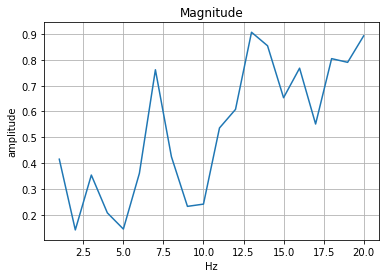

In [208]:
plt.plot(freq, plot_data)
plt.title('Magnitude')

plt.xlabel('Hz')
plt.ylabel('amplitude')
plt.grid(True)

## Feature Reduction

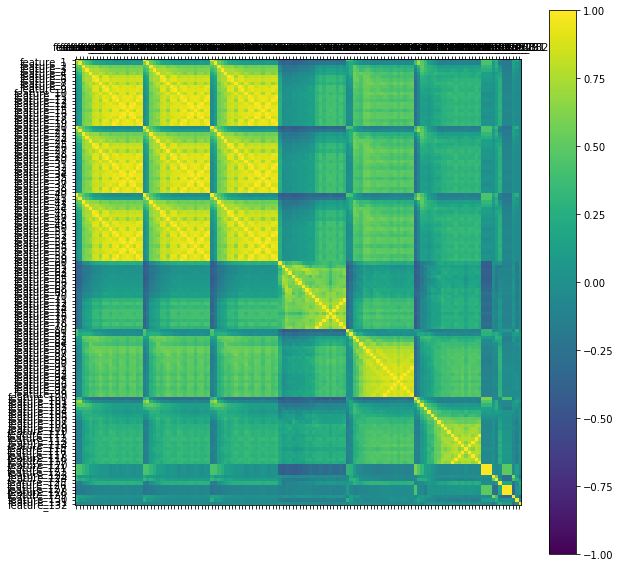

In [209]:
correlations = features_bobs.iloc[:, 2:].corr()

# plot correlation matrix
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(features_bobs.iloc[:, 2:].columns),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(features_bobs.iloc[:, 2:].columns)
ax.set_yticklabels(features_bobs.iloc[:, 2:].columns)
plt.show()

In [210]:
### drop features
# Select upper triangle of correlation matrix
upper = correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop features
original_length = len(features_bobs.iloc[:, 2:].columns)
features_bobs = features_bobs.drop(to_drop, axis=1)
print("Dropped {:.0f} features".format(original_length - len(features_bobs.iloc[:, 2:].columns)))

Dropped 70 features


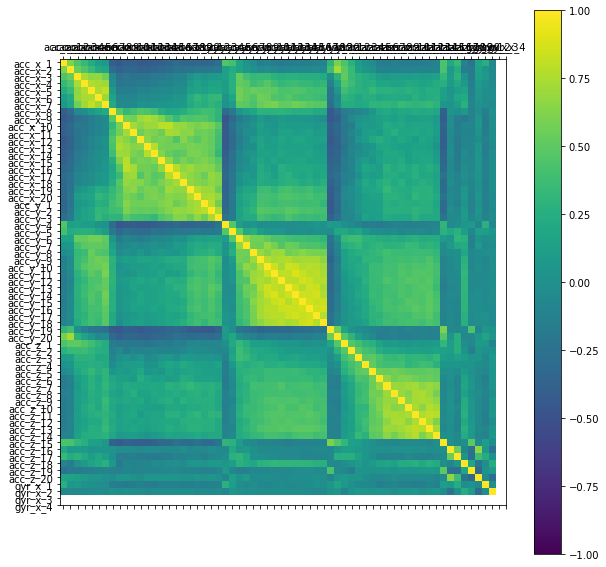

In [211]:
correlations = features_bobs.iloc[:, 2:].corr()

# plot correlation matrix
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(features_bobs.iloc[0]),1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(features_bobs.iloc[:, 2:].columns)
ax.set_yticklabels(features_bobs.iloc[:, 2:].columns)
plt.show()

## Data Partitioning

In [212]:
X = features_bobs.iloc[:,2:].values
y = data[0].iloc[:, 1].values

# Splitting the dataset into the Training set and Test set (dependent)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [214]:
# Splitting the dataset into the Training set and Test set (independent)
from sklearn.model_selection import train_test_split

X_train = features_bobs.loc[features["Participant"] != "bobs1", :].iloc[:,2:].values
X_test = features_bobs.loc[features["Participant"] == "bobs1", :].iloc[:,2:].values
y_train = features_bobs.loc[features["Participant"] != "bobs1", :].iloc[:,1].values
y_test = features_bobs.loc[features["Participant"] == "bobs1", :].iloc[:,1].values

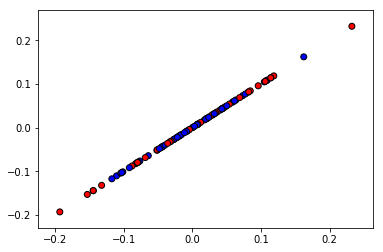

In [177]:
from pandas.plotting import scatter_matrix
from matplotlib.colors import ListedColormap

def plot_scatter(features, gestures, feature):
    ax = plt.subplot(1, 1, 1)
    data = features.loc[(features["Gesture"] == gestures[0]) | (features["Gesture"] == gestures[1]), feature] 
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    classes_scatter=features.loc[(features["Gesture"] == gestures[0]) | (features["Gesture"] == gestures[1]), "Gesture"]
    ax.scatter(data, data, c=classes_scatter, cmap=cm_bright, edgecolors='k')
    
plot_scatter(features, [0,9], 'gyr_x_median')

## Models

### Random Forest

In [178]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
    
def get_rf(X_train, y_train):
    # Number of trees in random forest
    n_estimators = np.power(range(1,18),3)
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = np.power(range(1,8),3)
    # Minimum number of samples required to split a node
    #min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    #min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    #bootstrap = [True, False]
    # Create the random grid
    param_grid = {
        'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        #'min_samples_split': min_samples_split,
        #'min_samples_leaf': min_samples_leaf,
        #'bootstrap': bootstrap
    }

    #clf_rf = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
    clf_rf = RandomForestClassifier(random_state=42)
    grid = GridSearchCV(clf_rf, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1, iid=False)

    grid.fit(X_train, y_train)
    return grid

In [179]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import cohen_kappa_score, make_scorer

def get_knn(X_train, y_train):
    # Number of trees in random forest
    n_neighbors = range(1,100)
    param_grid = {
        'n_neighbors': n_neighbors
    }
    
    clf = KNeighborsClassifier(n_neighbors=3)
    kappa_scorer = make_scorer(cohen_kappa_score)
    grid = GridSearchCV(clf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1, iid=False)

    grid.fit(X_train, y_train)
    return grid

In [ ]:
# RF
rf = get_rf(X_train, y_train)
print("[INFO] grid search best score: {}".format(rf.best_score_))
print("[INFO] grid search best parameters: {}".format(rf.best_params_))
acc = rf.score(X_test, y_test)
print("[INFO] grid search test accuracy: {:.2f}%".format(acc * 100))

Fitting 3 folds for each of 238 candidates, totalling 714 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  2.4min


In [215]:
# KNN
knn = get_knn(X_train, y_train)
print("[INFO] grid search best score: {}".format(knn.best_score_))
print("[INFO] grid search best parameters: {}".format(knn.best_params_))
acc = knn.score(X_test, y_test)
print("[INFO] grid search test accuracy: {:.2f}%".format(acc * 100))

Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    1.1s


[INFO] grid search best score: 0.9395833333333334
[INFO] grid search best parameters: {'n_neighbors': 3}
[INFO] grid search test accuracy: 73.33%


[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:    2.6s finished


## Test model

In [88]:
from sklearn.metrics import confusion_matrix

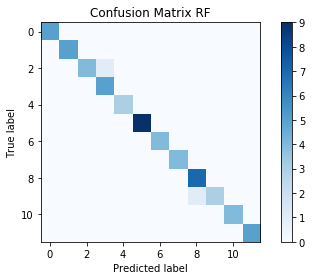

In [90]:
### Random Forest
rf_predicted_y = rf.predict(X_test)
rf_cm = confusion_matrix(y_test, rf_predicted_y)

plt.imshow(rf_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix RF")
plt.colorbar()

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

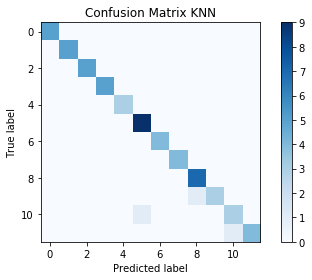

In [95]:
### KNN
knn_predicted_y = knn.predict(X_test)
knn_cm = confusion_matrix(y_test, knn_predicted_y)

plt.imshow(knn_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix KNN")
plt.colorbar()

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

## Evaluate Model

In [72]:
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, precision_score

In [73]:
### Random Forest
print(classification_report(y_test, rf_predicted_y))
print("Accuracy: %.3f" % accuracy_score(y_test, rf_predicted_y))
print("MSE: %.3f" % mean_squared_error(y_test, rf_predicted_y))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         2
           2       1.00      0.25      0.40         4
           3       0.25      1.00      0.40         1
           4       0.00      0.00      0.00         2
           5       1.00      1.00      1.00         2
           6       0.67      1.00      0.80         2
           7       1.00      0.33      0.50         3
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       1.00      0.33      0.50         3

   micro avg       0.35      0.35      0.35        23
   macro avg       0.41      0.33      0.30        23
weighted avg       0.59      0.35      0.37        23

Accuracy: 0.348
MSE: 20.478


C:\Users\x_oli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\x_oli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [74]:
### KNN
print(classification_report(y_test, knn_predicted_y))
print("Accuracy: %.3f" % accuracy_score(y_test, knn_predicted_y))
print("MSE: %.3f" % mean_squared_error(y_test, knn_predicted_y))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.33      0.50      0.40         2
           2       1.00      0.25      0.40         4
           3       0.25      1.00      0.40         1
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         2
           7       1.00      0.33      0.50         3
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         3

   micro avg       0.22      0.22      0.22        23
   macro avg       0.30      0.22      0.20        23
weighted avg       0.43      0.22      0.24        23

Accuracy: 0.217
MSE: 16.565


C:\Users\x_oli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\x_oli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Save Model

In [23]:
import pickle
filename = 'randomForest.model'
pickle.dump(rf, open(filename, 'wb'))

In [ ]:
import coremltools
coreml_model = coremltools.converters.sklearn.convert(rf)
coreml_model.save('RandomForest.mlmodel')